### Implementing Vision Transformer


In this notebook, we are going to take a deep dive into the implementation of vision transformers, with replicating the step in this monumental [paper](https://arxiv.org/pdf/2010.11929.pdf).


As I have done a thorough briefing in my previous notebooks regarding the Transformers which I used for solving NLP related task, in this notebook I will be as precise in my detailing as possible and showcasing important details whenever necessary.

But in this notebook also I will be building everything, starting from the Scaled Dot Product attention, all finally accumulating to the Vision Transformer architecture.


As always first up is the necessary imports.


In [1]:
## Necessary imports ##

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image

from torchvision.transforms import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt


In this notebook I am going to build up the Vision Transformer Network and in the next notebook I will utilizing this created Vision Transformer python module to run on a dataset.


Without further adieu, let get into it.

The first thing first is we are going to implement is the Scaled Dot Product Attention. Since, the Vision Transformer is nothing but an encoder of Transformer and there is no cross-attention involved and just self-attention, it will take a single input and make key, query and value out of it.

So, let's code it up.


#### Scaled Dot Product Attention


In [2]:
## Scaled Dot Product Attention ##


class ScaledDotProductAttention(nn.Module):
    """Implementation of the scaled dot product attention."""

    def __init__(self, embedding_dim):
        """Constructor."""

        super().__init__()

        # Query mapping
        self.query_map = nn.LazyLinear(out_features=embedding_dim, bias=False)

        # Key mapping
        self.key_map = nn.LazyLinear(out_features=embedding_dim, bias=False)

        # Value mapping
        self.value_map = nn.LazyLinear(out_features=embedding_dim, bias=False)

    def forward(self, x, return_wt=False):
        """Forward Pass."""

        # Query, key, value
        query, key, value = self.query_map(x), self.key_map(x), self.value_map(x)

        B, N, C = key.shape  # B -> batch, N -> Number of patches, C -> Each patch shape

        # Weight
        wei = (query @ key.transpose(-2, -1)) / C**0.5
        wei = F.softmax(wei, dim=-1)

        if return_wt:
            return wei @ value, wei

        return wei @ value


In [3]:
## Testing ##

torch.manual_seed(97)

attn = ScaledDotProductAttention(4)

inp = torch.randn(1, 2, 4)

val, wt = attn(inp, return_wt=True)

print(f"Output value : {val}")
print(f"Weight : {wt}")


Output value : tensor([[[ 0.3113, -0.8571, -0.3121, -0.5256],
         [ 0.0368, -0.9336, -0.0164, -0.6124]]], grad_fn=<UnsafeViewBackward0>)
Weight : tensor([[[0.4854, 0.5146],
         [0.2365, 0.7635]]], grad_fn=<SoftmaxBackward0>)


C:\ProgramData\Anaconda3\envs\pytorch_env\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Perfect...
Our output and the weight meet our expectations.

Moreover, one nice thing you might be able to observe is `nn.LazyLinear` which I used instead of `nn.Linear`. My only reason of using this is it makes everything simple, since in `nn.LazyLinear` you no longer need to give any input features shape anymore, making it much more flexible (at least for me!).


Next up we will build the Multi-head attention module.


#### Multi-head Attention


In [4]:
## Multihead Attention ##


class MultiheadAttention(nn.Module):
    """Implements Multihead Attention module."""

    def __init__(self, embedding_dim, num_heads):
        """Constructor"""

        super().__init__()

        # Setting each head output dim
        each_head_dim = embedding_dim // num_heads

        self.multi_head = nn.ModuleList(
            [ScaledDotProductAttention(each_head_dim) for _ in range(num_heads)]
        )

    def forward(self, x):
        """Forward Pass."""

        return torch.cat([head(x) for head in self.multi_head], dim=-1)


In [5]:
## Testing ##

torch.manual_seed(97)

mha = MultiheadAttention(embedding_dim=4, num_heads=2)

inp = torch.randn(1, 2, 4)

val = mha(inp)

print(f"Output value : {val}")

print(f"Output shape is {val.shape}")


Output value : tensor([[[ 0.5929,  0.7011, -0.4019, -0.4992],
         [ 0.5763,  0.7125, -0.0341, -0.6072]]], grad_fn=<CatBackward0>)
Output shape is torch.Size([1, 2, 4])


Nice. We are going quite fluently. Next we need to build up the mlp layer.

According to the ViT paper, they considered the MLP of two layers with GeLU non-linearity. We are going to utilize the same thing. The MLP dimension in the original Transformer layer is 4 times the normal the embedding dimension which is kept same in ViT.


In [6]:
## MLP ##


class MLP(nn.Module):
    """Implements the Pointwise FeedForward Network."""

    def __init__(self, embedding_dim):
        """Constructor"""

        super().__init__()

        self.mlp = nn.Sequential(
            nn.LazyLinear(4 * embedding_dim, bias=False),
            nn.GELU(),
            nn.LazyLinear(embedding_dim, bias=False),
        )

    def forward(self, x):
        """Forward Pass"""

        return self.mlp(x)


In [7]:
## Testing ##

torch.manual_seed(97)

mlp_1 = MLP(embedding_dim=4)

inp = torch.randn(1, 2, 4)

val = mlp_1(inp)

print(f"Output value : {val}")

print(f"Output shape is {val.shape}")


Output value : tensor([[[-0.1640,  0.3609,  0.2864,  0.1137],
         [-0.1189,  0.2112,  0.3023,  0.0959]]], grad_fn=<UnsafeViewBackward0>)
Output shape is torch.Size([1, 2, 4])


Nicely done....
Now what we need to do is build up a block for making the residual connections.


#### NormDropoutResidual Block


In [8]:
class NormDropoutResidual(nn.Module):
    """Implements LayernNorm, then Sublayer passthrough, dropout
    and then Residual Connection."""

    def __init__(self, embedding_dim, sublayer, dropout_rate=0.1):
        """Constructor"""

        super().__init__()

        self.block = nn.Sequential(
            nn.LayerNorm(embedding_dim), sublayer, nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        """Forward Pass"""

        return x + self.block(x)


In [9]:
## Testing ##

torch.manual_seed(97)

ndr = NormDropoutResidual(4, sublayer=MultiheadAttention(4, 2))

inp = torch.randn(1, 2, 4)

out = ndr(inp)

print(f"Output shape : {out.shape}")
print(f"Output is : {out}")


Output shape : torch.Size([1, 2, 4])
Output is : tensor([[[ 0.8387,  0.4856, -0.4679, -2.3831],
         [-0.1944,  0.6017, -2.1115, -1.1197]]], grad_fn=<AddBackward0>)


Now we will be building a single layer of the Encoder. This is nothing but a simple `NormDropoutResidual` block with `MultiheadAttention` sublayer followed by a `MLP` sublayer.


#### Single Encoder Layer


In [10]:
## Encoder Layer ##


class EncoderLayer(nn.Module):
    """Implements an Encoder Layer."""

    def __init__(self, embedding_dim, num_heads, dropout_rate=0.1):
        """Constructor"""

        super().__init__()

        self.block = nn.Sequential(
            NormDropoutResidual(
                embedding_dim,
                MultiheadAttention(embedding_dim, num_heads),
                dropout_rate,
            ),
            NormDropoutResidual(embedding_dim, MLP(embedding_dim), dropout_rate),
        )

    def forward(self, x):
        """Forward Pass"""
        return self.block(x)


In [11]:
## Testing ##

torch.manual_seed(97)

inp = torch.randn(1, 2, 4)

layer = EncoderLayer(embedding_dim=4, num_heads=2)

out = layer(inp)

print(f"Out : {out}")

print(f"Out shape : {out.shape}")


Out : tensor([[[ 1.0025,  0.0541, -0.8595, -2.4100],
         [-0.1944,  0.3606, -2.1115, -1.0094]]], grad_fn=<AddBackward0>)
Out shape : torch.Size([1, 2, 4])


Now before we build the encoder block, `Encoder`, which repeats the EncoderLayer $n$-times, we need to do two more things, one is the `PatchEmbedding` and `PositionalEmbedding` modules.


#### Positional Encoding


For Positional Encoding we will use the Sinusoidal 1-D encoding, since the paper shows no extra difference between this and any other learnable encodings.


In [12]:
## Positional Encoding ##


class PositionalEncoding(nn.Module):
    """Implementation of the Positional Encoding"""

    def __init__(self):
        """Constuctor"""

        super().__init__()

    def forward(self, sequence_length, embedding_dim):
        """Forward Pass"""

        positions = torch.arange(sequence_length).unsqueeze(-1)
        i = torch.arange(embedding_dim)

        position_embedding = torch.empty((sequence_length, embedding_dim))

        position_embedding[:, ::2] = torch.sin(
            positions / 1000 ** (i[::2] / embedding_dim)
        )
        position_embedding[:, 1::2] = torch.cos(
            positions / 1000 ** (i[1::2] / embedding_dim)
        )

        return position_embedding


In [13]:
## Testing ##

pos_enc = PositionalEncoding()

out = pos_enc(2, 4)

print(f"Output shape : {out.shape}")
print(f"Output : {out}")


Output shape : torch.Size([2, 4])
Output : tensor([[0.0000, 1.0000, 0.0000, 1.0000],
        [0.8415, 0.9842, 0.0316, 1.0000]])


Next up is the patch encoding module, which takes an image and splits into patches. We are not going to utilize the Hybrid model stated in the paper and instead stick to the basic implementation. This is one of the few things which you might find to be very new compared to a normal `Transformer`.

So lets first understand what `PatchEmbedding` is.

In general `Transformer` was built for NLP task and as input they were mapping each sequence of characters (or words) to a number which were passed through an embedding layer representing each words as a small vector representation (not one hot). Now in case of images also we need to do something like this to make it work. So, how to make an image as if it is a sequence of words? The answer is through `PatchEmbedding`.

What `PatchEmbedding` does is simply takes in a patch size, which is nothing but the size of a small patch of image which needs to is mapped as a sequence. Now this patch is p x p x c shaped. But our transformer expects it to be a flattened vector. How to do this? We simply flatten it to have a shape of (ppc). This is considered as a single sequence. We can make such N patches out of the image. Hence, using this we can provide N, ppc sequence to the transformer and that would perfectly work. This is done by the `PatchEmbedding` module.


#### Patch Embedding


In [14]:
## Patch Embedding Dummy##


class PatchEmbeddingDummy(nn.Module):
    """Implements the Patch Embedding."""

    def __init__(self, patch_shape):
        """Constructor"""

        super().__init__()

        self.patch_shape = patch_shape

        self.patch_embed = nn.Unfold(kernel_size=patch_shape, stride=patch_shape)

    def forward(self, img):
        """Forward pass"""

        B, C, _, _ = img.shape

        out = self.patch_embed(img)

        out = out.transpose(-2, -1)

        out = out.view(B, -1, C, self.patch_shape[0], self.patch_shape[1])

        return out


In [15]:
## testing ##

torch.manual_seed(97)

pe = PatchEmbeddingDummy((2, 2))

img = torch.randn(1, 3, 4, 4)

out = pe(img)

img_slice = img[:, :, :2, :2]
out_slice = out[:, 0, :, :, :]

print(f"Checking : {torch.allclose(img_slice,out_slice)}")
print(f"Input is : {img}")
print(f"Output : {out}")
print(f"Output shape : {out.shape}")


Checking : True
Input is : tensor([[[[-7.0149e-01,  8.4263e-01, -9.6157e-01, -1.8412e+00],
          [ 1.0544e+00,  1.5917e+00,  1.2750e+00, -1.5763e+00],
          [ 3.2234e-01,  4.4140e-01, -1.8075e-01,  1.3214e+00],
          [-4.0389e-01, -1.1014e+00, -1.4851e+00,  3.1440e-01]],

         [[ 9.9224e-01,  1.1436e-01,  8.9399e-01,  1.9282e-02],
          [-1.5573e-01,  1.9434e-01,  8.2715e-01, -8.8032e-01],
          [-1.6028e-01,  1.1792e+00, -2.8844e-01, -5.6181e-01],
          [-9.5597e-01, -2.4665e+00, -8.5740e-01, -1.9460e-01]],

         [[ 5.9543e-01, -1.7543e+00,  1.4713e+00, -2.3124e-01],
          [ 7.6927e-04,  1.2053e+00,  5.0362e-01,  2.0027e-01],
          [-1.0537e-01, -9.8431e-01, -5.7025e-01,  1.9230e-01],
          [ 8.0840e-01, -5.3518e-02, -2.9423e-01, -4.9692e-01]]]])
Output : tensor([[[[[-7.0149e-01,  8.4263e-01],
           [ 1.0544e+00,  1.5917e+00]],

          [[ 9.9224e-01,  1.1436e-01],
           [-1.5573e-01,  1.9434e-01]],

          [[ 5.9543e-01, -1.7

I wanted to test it more... So, I will do one more sanity check with an image to confirm that our formulation is actually correct.


Output shape : torch.Size([1, 25, 3, 50, 50])


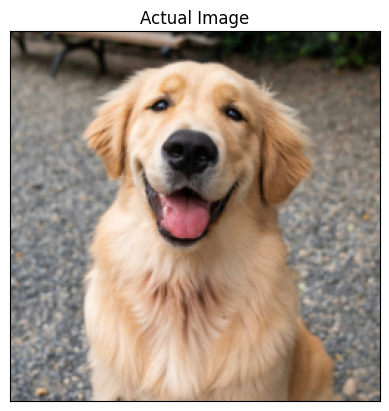

Total patches : 25


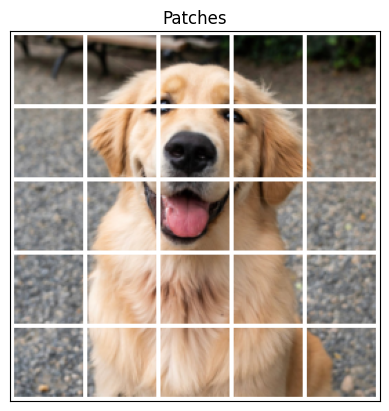

In [16]:
## Testing v2 ##

img = Image.open("dog.jpg")

aug = transforms.Compose([transforms.Resize((250, 250)), transforms.ToTensor()])

img_tensor = aug(img)
patch_shape = (50, 50)

patch_embed = PatchEmbeddingDummy(patch_shape)

patches = patch_embed(img_tensor.unsqueeze(0))

print(f"Output shape : {patches.shape}")


plt.title(f"Actual Image")
plt.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
plt.imshow(transforms.ToPILImage()(img_tensor))
plt.show()

total_patches = patches.shape[1]

print(f"Total patches : {total_patches}")

n_rows = int(total_patches**0.5)

plt.title("Patches")
plt.imshow(make_grid(patches[0], n_rows, padding=3, pad_value=1).permute(1, 2, 0))
plt.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
plt.show()


Our module is perfect.

But you might not have noticed it, but I wrote the `PatchEmbeddingDummy` module and not `PatchEmbedding` module. The catch is we don't need to return image of the patches. What I mean is we don't need to reshape to `(B, Num_Patches, C, Patch_shape[0], Patch_Shape[1])`, but we just need to return `(B, Num_Patches, C * Patch_shape[0] * Patch_Shape[1])` which would be very simple and we are going to do next which would be our actual `PatchEmbedding` module.


In [17]:
## Patch Embedding ##


class PatchEmbedding(nn.Module):
    """Implements the Patch Embedding."""

    def __init__(self, patch_shape):
        """Constructor"""

        super().__init__()

        self.patch_shape = patch_shape

        self.patch_embed = nn.Unfold(kernel_size=patch_shape, stride=patch_shape)

    def forward(self, img):
        """Forward pass"""

        B, C, _, _ = img.shape

        out = self.patch_embed(img)

        out = out.transpose(-2, -1)

        return out


In [18]:
## testing ##

torch.manual_seed(97)

patch_enc = PatchEmbedding((2, 2))

img = torch.randn(1, 3, 4, 4)

out = patch_enc(img)

print(f"Output shape : {out.shape}")


Output shape : torch.Size([1, 4, 12])


And done....

We are everybit ready with our work to finally build the last few pieces of ViT.

First up is the encoder block.


#### Encoder


In [19]:
## Encoder ##


class Encoder(nn.Module):
    """Implementation of the Encoder Block."""

    def __init__(self, embedding_dim, num_heads, num_layers, dropout_rate=0.1):
        """Constructor"""

        super().__init__()

        self.encoder = nn.ModuleList(
            [
                EncoderLayer(embedding_dim, num_heads, dropout_rate)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x):
        """Forward Pass"""

        for layer in self.encoder:
            x = layer(x)

        return x


In [20]:
## Testing ##

torch.manual_seed(97)

enc = Encoder(embedding_dim=64, num_heads=4, num_layers=6, dropout_rate=0.1)

inp = torch.randn(2, 2, 64)

print(f"Output is {enc(inp).shape}")


Output is torch.Size([2, 2, 64])


Perfect... Everything works...

Now its time to finally build our ViT module.


#### Vision Transformer


In [21]:
## Vision Transformer ##


class VisionTransformer(nn.Module):
    """Implements the Vision Transformer Module."""

    def __init__(
        self,
        patch_shape,
        embedding_dim,
        num_heads,
        num_layers,
        num_classes,
        dropout_rate=0.1,
    ):
        """Constructor"""

        super().__init__()

        self.patch_embedding = PatchEmbedding(patch_shape)

        self.linear_projection_patches = nn.LazyLinear(out_features=embedding_dim)

        self.class_token = nn.Parameter(torch.zeros(1, 1, embedding_dim))

        self.position_embedding = PositionalEncoding()

        self.encoder = Encoder(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            dropout_rate=dropout_rate,
        )

        self.classifer = nn.LazyLinear(num_classes)

    def forward(self, img):
        """Forward Pass"""

        img_patches = self.patch_embedding(img)

        img_patches = self.linear_projection_patches(img_patches)

        # Adding class token

        B, L, C = img_patches.shape

        img_patches = torch.cat(
            [self.class_token.expand(B, -1, -1), img_patches], dim=1
        )

        positional_embedding = self.position_embedding(
            sequence_length=L + 1, embedding_dim=C
        )

        img_patches += positional_embedding

        encoder_out = self.encoder(img_patches)

        encoder_out_class_token = encoder_out[:, 0, :]

        return self.classifer(encoder_out_class_token)


In [22]:
## Testing ##

torch.manual_seed(97)

vit = VisionTransformer(
    (5, 5), embedding_dim=32, num_heads=8, num_layers=5, num_classes=2
)

inp = torch.randn(2, 3, 25, 25)

out = vit(inp)

print(f"Output is {out} and shape is {out.shape}")


Output is tensor([[0.3412, 0.5655],
        [0.1545, 0.2508]], grad_fn=<AddmmBackward0>) and shape is torch.Size([2, 2])


And we are done. We have built our very own Vision Transformer.

I will transformer these into a python module such that we can utilize this in our next notebook to build an example project.
